In [ ]:

# ===================================================================
# Telnet Attack 
# Network Security Project 
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, balanced_accuracy_score)
import warnings
warnings.filterwarnings('ignore')

In [432]:
df = pd.read_csv(r'..\Dataset\final_datasetv3.csv')


In [433]:
print(f" Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names:\n{df.columns.tolist()}")

 Dataset loaded: 5725 rows × 12 columns

Column names:
['frame.time_epoch', 'frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.proto', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.len', 'tcp.stream', 'tcp.window_size', 'label']


In [434]:
df.head()

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size,label
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888,0


In [435]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   frame.time_epoch     5725 non-null   object
 1   frame.time_delta     5725 non-null   object
 2   frame.time_relative  5725 non-null   object
 3   frame.len            5725 non-null   object
 4   ip.proto             5725 non-null   object
 5   tcp.srcport          5725 non-null   object
 6   tcp.dstport          5725 non-null   object
 7   tcp.flags            5725 non-null   object
 8   tcp.len              5725 non-null   object
 9   tcp.stream           5725 non-null   object
 10  tcp.window_size      5725 non-null   object
 11  label                5725 non-null   object
dtypes: object(12)
memory usage: 536.8+ KB
None


In [436]:
label_counts = df['label'].value_counts()
print(f"\n Label Distribution:")
print(f"   Normal (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.2f}%)")
print(f"   Attack (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.2f}%)")


 Label Distribution:
   Normal (0): 3125 (54.59%)
   Attack (1): 2599 (45.40%)


In [437]:
missing = df.isnull().sum()
print(f"\n Missing Values per Feature:")
for col, miss in missing.items():
    if miss > 0:
        print(f"   {col}: {miss} ({miss/len(df)*100:.2f}%)")
if missing.sum() == 0:
    print("  No missing values found!")


 Missing Values per Feature:
  No missing values found!


In [438]:
duplicates = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates}")


 Duplicate Rows: 0


In [439]:
print(df.describe())


            frame.time_epoch frame.time_delta frame.time_relative frame.len  \
count                   5725             5725                5725      5725   
unique                  5725             5699                5725        46   
top     1765999986.825697327      0.000020219         0.001675444        66   
freq                       1                2                   1      2785   

       ip.proto tcp.srcport tcp.dstport tcp.flags tcp.len tcp.stream  \
count      5725        5725        5725      5725    5725       5725   
unique        2         345         345         8      44        237   
top           6          23          23    0x0018       0          3   
freq       5724        1555        1777      2232    3492        236   

       tcp.window_size label  
count             5725  5725  
unique              22     3  
top               5888     1  
freq              2155  3125  


In [440]:
df_clean = df.dropna()

In [441]:
label_counts = df['label'].value_counts()
print(f"\n Label Distribution:")
print(f"   Normal (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.2f}%)")
print(f"   Attack (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.2f}%)")


 Label Distribution:
   Normal (0): 3125 (54.59%)
   Attack (1): 2599 (45.40%)


In [442]:
print(f" Final dataset: {len(df_clean)} rows")

 Final dataset: 5725 rows


In [443]:
X = df_clean.drop('label', axis=1)
y = df_clean['label']

In [444]:
X.select_dtypes(include='object').head()


,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888


In [445]:
print(X['tcp.flags'].unique()[:20])

['0x0002' '0x0012' '0x0010' '0x0018' '0x0011' '0x0004' 'tcp.flags'
 '0x0014']


In [446]:
flags = {
    'FIN': 0x01,
    'SYN': 0x02,
    'RST': 0x04,
    'PSH': 0x08,
    'ACK': 0x10,
    'URG': 0x20
}

def safe_flag(x, value):
    try:
        return int(x, 16) & value > 0
    except:
        return 0  

for flag, value in flags.items():
    X[f'tcp_{flag}'] = X['tcp.flags'].apply(lambda x: safe_flag(x, value)).astype(int)


In [447]:
X

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.flags,tcp.len,tcp.stream,tcp.window_size,tcp_FIN,tcp_SYN,tcp_RST,tcp_PSH,tcp_ACK,tcp_URG
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0x0002,0,0,64240,0,1,0,0,0,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0x0012,0,0,5792,0,1,0,0,1,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0x0010,0,0,64256,0,0,0,0,1,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,0x0018,72,0,64256,0,0,0,1,1,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0x0010,0,0,5888,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,1766002344.544042131,0.000054809,306.175677910,66,6,46249,23,0x0010,0,104,63744,0,0,0,0,1,0
5721,1766002344.565819459,0.021777328,306.197455238,88,6,23,46249,0x0018,22,104,5888,0,0,0,1,1,0
5722,1766002344.565848007,0.000028548,306.197483786,66,6,46249,23,0x0010,0,104,63744,0,0,0,0,1,0
5723,1766002344.999736630,0.433888623,306.631372409,66,6,46249,23,0x0011,0,104,63744,1,0,0,0,1,0


In [448]:
X = X.drop(columns=['tcp.flags'])

In [449]:
flag_cols = ['tcp_FIN','tcp_SYN','tcp_RST','tcp_PSH','tcp_ACK','tcp_URG']
X[flag_cols] = X[flag_cols].astype(int)

In [450]:
X

,frame.time_epoch,frame.time_delta,frame.time_relative,frame.len,ip.proto,tcp.srcport,tcp.dstport,tcp.len,tcp.stream,tcp.window_size,tcp_FIN,tcp_SYN,tcp_RST,tcp_PSH,tcp_ACK,tcp_URG
0,1765999986.825697327,0.000008343,0.001675444,74,6,41482,80,0,0,64240,0,1,0,0,0,0
1,1765999986.826979484,0.001282157,0.002957601,74,6,80,41482,0,0,5792,0,1,0,0,1,0
2,1765999986.827214455,0.000234971,0.003192572,66,6,41482,80,0,0,64256,0,0,0,0,1,0
3,1765999986.828629836,0.001415381,0.004607953,138,6,41482,80,72,0,64256,0,0,0,1,1,0
4,1765999986.830126872,0.001497036,0.006104989,66,6,80,41482,0,0,5888,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,1766002344.544042131,0.000054809,306.175677910,66,6,46249,23,0,104,63744,0,0,0,0,1,0
5721,1766002344.565819459,0.021777328,306.197455238,88,6,23,46249,22,104,5888,0,0,0,1,1,0
5722,1766002344.565848007,0.000028548,306.197483786,66,6,46249,23,0,104,63744,0,0,0,0,1,0
5723,1766002344.999736630,0.433888623,306.631372409,66,6,46249,23,0,104,63744,1,0,0,0,1,0


In [451]:
y

0       0
1       0
2       0
3       0
4       0
       ..
5720    1
5721    1
5722    1
5723    1
5724    1
Name: label, Length: 5725, dtype: object

In [452]:
X = X.drop(columns=['frame.time_epoch','frame.time_delta','frame.time_relative','tcp.srcport', 'tcp.dstport'])

In [453]:
# Convert all features to numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = y[X.index]

y = y.astype(int)
y = y[y.isin([0, 1])]
X = X.loc[y.index]

print(f"After preprocessing: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Label distribution:\n{y.value_counts()}")

After preprocessing: 5724 samples, 11 features
Label distribution:
label
1    3125
0    2599
Name: count, dtype: int64


In [454]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Temporary split for feature selection:")
print(f"  Training: {X_train_temp.shape[0]} samples")
print(f"  Testing: {X_test_temp.shape[0]} samples")

rfe_selector = RFE(
    estimator=RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    n_features_to_select=5,
    step=1
)
rfe_selector.fit(X_train_temp, y_train_temp)
rfe_ranking = rfe_selector.ranking_
rfe_importance = 1 / rfe_ranking 

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rfe_importance
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance (from training data only):")
print(feature_importance)
top_features = feature_importance.head(5)['feature'].tolist()
print(f"\nSelected Top 5 Features: {top_features}")

X_train_selected = X_train_temp[top_features]
X_test_selected = X_test_temp[top_features]
y_train_selected = y_train_temp
y_test_selected = y_test_temp

Temporary split for feature selection:
  Training: 4579 samples
  Testing: 1145 samples

Feature Importance (from training data only):
            feature  importance
0         frame.len    1.000000
2           tcp.len    1.000000
3        tcp.stream    1.000000
8           tcp_PSH    1.000000
4   tcp.window_size    1.000000
5           tcp_FIN    0.500000
6           tcp_SYN    0.333333
7           tcp_RST    0.250000
9           tcp_ACK    0.200000
10          tcp_URG    0.166667
1          ip.proto    0.142857

Selected Top 5 Features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_PSH', 'tcp.window_size']


In [455]:
print(f"Using selected features: {top_features}")
print(f"Final dataset shape: Train={X_train_selected.shape}, Test={X_test_selected.shape}")

Using selected features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_PSH', 'tcp.window_size']
Final dataset shape: Train=(4579, 5), Test=(1145, 5)


In [456]:
# split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_selected, y_train_selected, test_size=0.15, random_state=42, stratify=y_train_selected
)

# Keep test set separate (never used for training or validation)
X_test = X_test_selected.copy()
y_test = y_test_selected.copy()

print(f"Final splits:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")
print(f"\nTraining label distribution:\n{y_train.value_counts()}")

Final splits:
  Training: 3892 samples
  Validation: 687 samples
  Testing: 1145 samples

Training label distribution:
label
1    2125
0    1767
Name: count, dtype: int64


In [457]:
# from imblearn.combine import SMOTETomek

# smt = SMOTETomek(random_state=42)
# X_train, y_train = smt.fit_resample(X_train, y_train)


In [458]:
print(y_train.value_counts())
print(pd.Series(y_train).value_counts())


label
1    2125
0    1767
Name: count, dtype: int64
label
1    2125
0    1767
Name: count, dtype: int64


In [459]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 3892 samples
Testing set: 1145 samples


In [460]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)  

In [461]:
# Random Forest with cross-validation
print("="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Train on full training set
rf_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_val = rf_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")

# Final evaluation on test set
y_pred = rf_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

RANDOM FOREST CLASSIFIER
Cross-validation F1 scores: [0.90742857 0.88964733 0.89088864 0.88788222 0.88248848]
Mean CV F1: 0.8917 (+/- 0.0168)

Validation Set Performance:
  F1: 0.8977
  Balanced Accuracy: 0.8783

Test Set Performance:
  Accuracy: 0.8821
  Precision: 0.8679
  Recall: 0.9248
  F1-Score: 0.8954
  Balanced Accuracy: 0.8778

Confusion Matrix:
[[432  88]
 [ 47 578]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       520
           1       0.87      0.92      0.90       625

    accuracy                           0.88      1145
   macro avg       0.88      0.88      0.88      1145
weighted avg       0.88      0.88      0.88      1145



In [462]:
# SVM with cross-validation
print("="*60)
print("SVM (RBF) CLASSIFIER")
print("="*60)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma='scale', 
    class_weight='balanced',
    random_state=42,
    probability=True
)

cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Train on full training set
svm_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_val = svm_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")

# Final evaluation on test set
y_pred = svm_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

SVM (RBF) CLASSIFIER
Cross-validation F1 scores: [0.84549356 0.83189655 0.82461538 0.82751092 0.85074627]
Mean CV F1: 0.8361 (+/- 0.0205)

Validation Set Performance:
  F1: 0.8283
  Balanced Accuracy: 0.7835

Test Set Performance:
  Accuracy: 0.8017
  Precision: 0.7618
  Recall: 0.9264
  F1-Score: 0.8361
  Balanced Accuracy: 0.7892

Confusion Matrix:
[[339 181]
 [ 46 579]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       520
           1       0.76      0.93      0.84       625

    accuracy                           0.80      1145
   macro avg       0.82      0.79      0.79      1145
weighted avg       0.82      0.80      0.80      1145



In [463]:
# Decision Tree 
print("="*60)
print("DECISION TREE CLASSIFIER")
print("="*60)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_model = DecisionTreeClassifier(
    max_depth=10, 
    class_weight='balanced',
    min_samples_split=20,  
    min_samples_leaf=10,   
    random_state=42
)

cv_scores = cross_val_score(dt_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Train on full training set
dt_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_pred_val = dt_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")

# Final evaluation on test set
y_pred = dt_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

DECISION TREE CLASSIFIER
Cross-validation F1 scores: [0.89916963 0.89298044 0.88174512 0.88054608 0.87706856]
Mean CV F1: 0.8863 (+/- 0.0167)

Validation Set Performance:
  F1: 0.8932
  Balanced Accuracy: 0.8772

Test Set Performance:
  Accuracy: 0.8943
  Precision: 0.8853
  Recall: 0.9264
  F1-Score: 0.9054
  Balanced Accuracy: 0.8911

Confusion Matrix:
[[445  75]
 [ 46 579]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       520
           1       0.89      0.93      0.91       625

    accuracy                           0.89      1145
   macro avg       0.90      0.89      0.89      1145
weighted avg       0.89      0.89      0.89      1145



In [464]:
# XGBoost 
print("="*60)
print("XGBOOST CLASSIFIER")
print("="*60)

xgb_model = XGBClassifier(
    n_estimators=500,  
    max_depth=6, 
    learning_rate=0.1, 
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)


# Cross-validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Final evaluation on test set
y_pred = xgb_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Balanced Accuracy: {bal_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

XGBOOST CLASSIFIER
Cross-validation F1 scores: [0.88966318 0.88685714 0.87991021 0.86146682 0.8618267 ]
Mean CV F1: 0.8759 (+/- 0.0242)

Test Set Performance:
  Accuracy: 0.8742
  Precision: 0.8627
  Recall: 0.9152
  F1-Score: 0.8882
  Balanced Accuracy: 0.8701

Confusion Matrix:
[[429  91]
 [ 53 572]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86       520
           1       0.86      0.92      0.89       625

    accuracy                           0.87      1145
   macro avg       0.88      0.87      0.87      1145
weighted avg       0.88      0.87      0.87      1145



In [465]:
# LightGBM with early stopping and regularization
print("="*60)
print("LIGHTGBM CLASSIFIER")
print("="*60)

lgbm_model = LGBMClassifier(
    n_estimators=500,  
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1, 
    n_jobs=-1
)

LIGHTGBM CLASSIFIER


In [466]:
lgbm_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_val_scaled, y_val)],  # Use validation set, not test set
    eval_metric='binary_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
)

print(f"Best iteration: {lgbm_model.best_iteration_ if hasattr(lgbm_model, 'best_iteration_') else 'N/A'}")

# Cross-validation
cv_scores = cross_val_score(lgbm_model, X_train_scaled, y_train, cv=cv, 
                            scoring='f1', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Best iteration: 49
Cross-validation F1 scores: [0.88262911 0.87972509 0.86332574 0.85245902 0.85414236]
Mean CV F1: 0.8665 (+/- 0.0252)


In [467]:
# Evaluate on validation set first
y_pred_val_lgbm = lgbm_model.predict(X_val_scaled)
print(f"\nValidation Set Performance:")
print(f"  F1: {f1_score(y_val, y_pred_val_lgbm):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val_lgbm):.4f}")

# Final evaluation on test set
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
prec_lgbm = precision_score(y_test, y_pred_lgbm)
rec_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
bal_acc_lgbm = balanced_accuracy_score(y_test, y_pred_lgbm)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)


Validation Set Performance:
  F1: 0.9072
  Balanced Accuracy: 0.8879


In [468]:
print(f"\nTest Set Performance:")
print(f"  Accuracy: {acc_lgbm:.4f}")
print(f"  Precision: {prec_lgbm:.4f}")
print(f"  Recall: {rec_lgbm:.4f}")
print(f"  F1-Score: {f1_lgbm:.4f}")
print(f"  Balanced Accuracy: {bal_acc_lgbm:.4f}")
print(f"\nConfusion Matrix:\n{cm_lgbm}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_lgbm)}")


Test Set Performance:
  Accuracy: 0.8934
  Precision: 0.8693
  Recall: 0.9472
  F1-Score: 0.9066
  Balanced Accuracy: 0.8880

Confusion Matrix:
[[431  89]
 [ 33 592]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       520
           1       0.87      0.95      0.91       625

    accuracy                           0.89      1145
   macro avg       0.90      0.89      0.89      1145
weighted avg       0.90      0.89      0.89      1145



In [ ]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, 
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', 
        C=10.0,  
        gamma='scale', 
        class_weight='balanced',
        random_state=42,
        probability=True
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300,
        max_depth=5, 
        learning_rate=0.05, 
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=500,
        subsample=0.8, 
        reg_lambda=0.1, 
        reg_alpha=0.1, 
        num_leaves=50, 
        min_child_samples=10, 
        max_depth=15, 
        learning_rate=0.05, 
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )
}

In [ ]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    try:
        # Cross-validation on training set
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, 
                                    scoring='f1', n_jobs=-1)
        print(f"Cross-validation F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
        
        # Train with early stopping for gradient boosting models
        if name == 'XGBoost':
            model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_val_scaled, y_val)],
                verbose=False
            )
        elif name == 'LightGBM':
            model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_val_scaled, y_val)],
                eval_metric='binary_logloss'
            )
        else:
            model.fit(X_train_scaled, y_train)
        
        # Evaluate on validation set
        y_pred_val = model.predict(X_val_scaled)
        val_f1 = f1_score(y_val, y_pred_val)
        print(f"Validation F1: {val_f1:.4f}")
        
        # Final evaluation on test set
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std(),
            'val_f1': val_f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'balanced_accuracy': bal_acc,
            'confusion_matrix': cm,
            'predictions': y_pred
        }
        
        print(f"Test F1: {f1:.4f}")
        
    except Exception as e:
        print(f" Error training {name}: {str(e)}")
        continue


Training Random Forest...
Cross-validation F1: 0.8769 (+/- 0.0152)
Validation F1: 0.8827
Test F1: 0.8833

Training SVM (RBF)...
Cross-validation F1: 0.8341 (+/- 0.0189)
Validation F1: 0.8348
Test F1: 0.8409

Training XGBoost...
Cross-validation F1: 0.9002 (+/- 0.0170)
Validation F1: 0.9031
Test F1: 0.8986

Training LightGBM...
Cross-validation F1: 0.8654 (+/- 0.0252)
Validation F1: 0.8829
Test F1: 0.8807


In [471]:
if len(results) > 0:
    best_model_name = max(results.items(), key=lambda x: x[1]['f1_score'])[0]
    best_f1 = results[best_model_name]['f1_score']
    best_recall = results[best_model_name]['recall']
    print(f" Best Model Automatically Selected: {best_model_name}")
    print(f"   Test F1-Score: {best_f1:.4f}")
    print(f"   Test Recall: {best_recall:.4f} (Critical for IDS!)")
    print(f"   Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
else:
    best_model_name = 'LightGBM'  # Fallback
    print(f"  No results available. Using default: {best_model_name}")


 Best Model Automatically Selected: XGBoost
   Test F1-Score: 0.8986
   Test Recall: 0.9360 (Critical for IDS!)
   Test Accuracy: 0.8847


In [472]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_F1_Mean': [r['cv_f1_mean'] for r in results.values()],
    'CV_F1_Std': [r['cv_f1_std'] for r in results.values()],
    'Val_F1': [r['val_f1'] for r in results.values()],
    'Test_Accuracy': [r['accuracy'] for r in results.values()],
    'Test_Precision': [r['precision'] for r in results.values()],
    'Test_Recall': [r['recall'] for r in results.values()],
    'Test_F1': [r['f1_score'] for r in results.values()],
    'Balanced_Accuracy': [r['balanced_accuracy'] for r in results.values()]
})

In [473]:
print(comparison_df.to_string(index=False))

        Model  CV_F1_Mean  CV_F1_Std   Val_F1  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Balanced_Accuracy
Random Forest    0.876906   0.007612 0.882740       0.870742        0.870918       0.8960 0.883281           0.868192
    SVM (RBF)    0.834053   0.009457 0.834783       0.811354        0.778990       0.9136 0.840943           0.801031
      XGBoost    0.900174   0.008512 0.903061       0.884716        0.864106       0.9360 0.898618           0.879538
     LightGBM    0.866656   0.013426 0.881443       0.865502        0.859542       0.9008 0.879687           0.861938


In [474]:
for name, result in results.items():
    print(f"\n{name}:")
    cm = result['confusion_matrix']
    print(f"\nConfusion Matrix:")
    print(f"                Predicted Normal  Predicted Attack")
    print(f"Actual Normal   {cm[0][0]:^16}  {cm[0][1]:^16}")
    print(f"Actual Attack   {cm[1][0]:^16}  {cm[1][1]:^16}")
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nTrue Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}") 
    print(f"True Positives (TP):  {tp}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, result['predictions'], 
                                target_names=['Normal', 'Attack']))


Random Forest:

Confusion Matrix:
                Predicted Normal  Predicted Attack
Actual Normal         437                83       
Actual Attack          65               560       

True Negatives (TN):  437
False Positives (FP): 83
False Negatives (FN): 65
True Positives (TP):  560

Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.84      0.86       520
      Attack       0.87      0.90      0.88       625

    accuracy                           0.87      1145
   macro avg       0.87      0.87      0.87      1145
weighted avg       0.87      0.87      0.87      1145


SVM (RBF):

Confusion Matrix:
                Predicted Normal  Predicted Attack
Actual Normal         358               162       
Actual Attack          54               571       

True Negatives (TN):  358
False Positives (FP): 162
False Negatives (FN): 54
True Positives (TP):  571

Classification Report:
              precision    recall  f1-score   

Visualization saved as 'model_comparison.png'


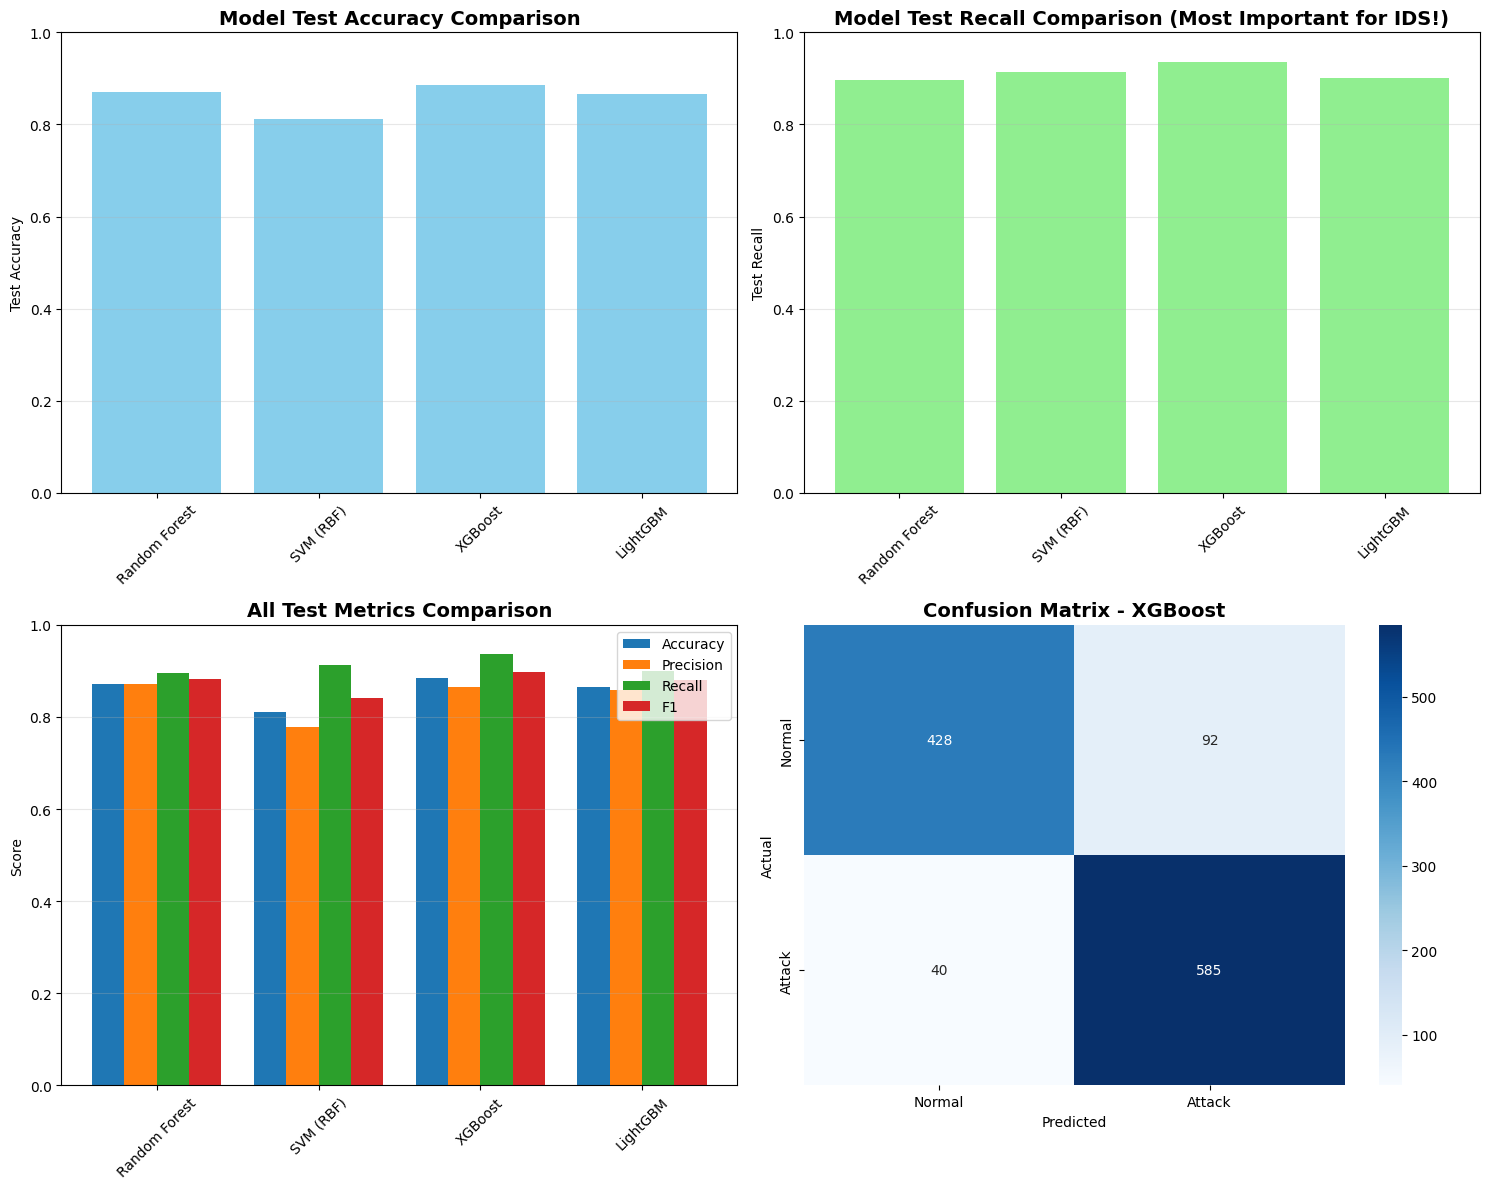

In [475]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test Accuracy comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test_Accuracy'], color='skyblue')
axes[0, 0].set_title('Model Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_ylim([0, 1.0])
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Test Recall comparison (most important for IDS!)
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test_Recall'], color='lightgreen')
axes[0, 1].set_title('Model Test Recall Comparison (Most Important for IDS!)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Test Recall')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# All test metrics comparison
metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[1, 0].bar(x + i*width, comparison_df[metric], width, 
                   label=metric.replace('Test_', ''))

axes[1, 0].set_title('All Test Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x + width * 1.5)
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.0])
axes[1, 0].grid(axis='y', alpha=0.3)

# Confusion matrix for best model
cm_best = results[best_model_name]['confusion_matrix']
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'], ax=axes[1, 1])
axes[1, 1].set_title(f'Confusion Matrix - {best_model_name}', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'model_comparison.png'")

In [476]:
import joblib

# Save the best model (LightGBM based on results)
best_model = results[best_model_name]['model']
print("best model" , best_model)
joblib.dump(best_model, r'..\saved models\lgbm_telnet_ids_model.pkl')
joblib.dump(scaler, r'..\saved models\scalerlgbm.pkl')
joblib.dump(top_features, r'..\saved models\featureslgbm.pkl')  # Use top_features from feature selection

print("Model, scaler, and features saved successfully!")
print(f"Saved features: {top_features}")

best model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)
Model, scaler, and features saved successfully!
Saved features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_PSH', 'tcp.window_size']


In [477]:
import joblib
import pandas as pd
import numpy as np

model = joblib.load(r'..\saved models\lgbm_telnet_ids_model.pkl')
scaler = joblib.load(r'..\saved models\scalerlgbm.pkl')
features = joblib.load(r'..\saved models\featureslgbm.pkl')

def predict_attack(sample_dict):
    df = pd.DataFrame([sample_dict])
    missing_features = set(features) - set(df.columns)
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    df = df[features]
    df = df.apply(pd.to_numeric, errors='coerce')
    if df.isnull().any().any():
        raise ValueError(f"NaN values found in features: {df.columns[df.isnull().any()].tolist()}")
    df_scaled = scaler.transform(df)
    pred = model.predict(df_scaled)[0]
    prob = model.predict_proba(df_scaled)[0]
    
    return {
        "prediction": "ATTACK" if pred == 1 else "NORMAL",
        "attack_probability": float(prob[1]),
        "normal_probability": float(prob[0])
    }

sample_attack = {
    'frame.len': 138,
    'tcp.len': 72,
    'tcp.stream': 104,
    'tcp_PSH': 1,
    'tcp.window_size': 5888
}

sample_normal = {
    'frame.len': 66,
    'tcp.len': 0,
    'tcp.stream': 0,
    'tcp_PSH': 0,
    'tcp.window_size': 64240
}

print("="*50)
print("TESTING ATTACK DETECTION MODEL")
print("="*50)
print(f"Using features: {features}")

print("\n1. Sample 1 (Expected: ATTACK):")
try:
    result1 = predict_attack(sample_attack)
    print(f"   Prediction: {result1['prediction']}")
    print(f"   Attack Probability: {result1['attack_probability']:.2%}")
    print(f"   Normal Probability: {result1['normal_probability']:.2%}")
except Exception as e:
    print(f"   Error: {e}")

print("\n2. Sample 2 (Expected: NORMAL):")
try:
    result2 = predict_attack(sample_normal)
    print(f"   Prediction: {result2['prediction']}")
    print(f"   Attack Probability: {result2['attack_probability']:.2%}")
    print(f"   Normal Probability: {result2['normal_probability']:.2%}")
except Exception as e:
    print(f"   Error: {e}")

TESTING ATTACK DETECTION MODEL
Using features: ['frame.len', 'tcp.len', 'tcp.stream', 'tcp_PSH', 'tcp.window_size']

1. Sample 1 (Expected: ATTACK):
   Prediction: NORMAL
   Attack Probability: 8.90%
   Normal Probability: 91.10%

2. Sample 2 (Expected: NORMAL):
   Prediction: ATTACK
   Attack Probability: 60.63%
   Normal Probability: 39.37%
